# Challenge Part 2: Sentiment Classifier

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import my_utils

Having already trained the language model, it is time to use it for the actual task!

In [3]:
VERSION = 'v1'

DATA_PATH = 'data/%s/' % VERSION

import os
os.makedirs(DATA_PATH, exist_ok=True)

## Loading the dataset

We will load the already pre-processed text data. However for the classification task, we only care about the strongly positive and negative examples, so we will filter out the neutral ones.

In [4]:
with open('data/lm/tweet_data.pkl', 'rb') as f:
    df = pickle.load(f)

df.groupby('sentiment').count()

,text
sentiment,
negative,9178
neutral,3099
positive,2363


In [5]:
df_labeled = df[df['sentiment'] != 'neutral']

df_labeled.groupby('sentiment').count()

,text
sentiment,
negative,9178
positive,2363


In [6]:
df_labeled.head(10)

,text,sentiment
1,plus you've added commercials to the experienc...,positive
3,"it's really aggressive to blast obnoxious "" en...",negative
4,and it's a really big bad thing about it,negative
5,seriously would pay $ 30 a flight for seats th...,negative
6,"yes , nearly every time I fly VX this “ ear wo...",positive
8,"Well , I didn't … but NOW I DO ! :-D",positive
9,"it was amazing , and arrived an hour early . Y...",positive
11,I <3 pretty graphics . so much better than min...,positive
12,This is such a great deal ! Already thinking a...,positive
13,xxhan I'm flying your fabulous Seductive skies...,positive


In order to have reproducible results, I will set a fixed random seed, and set the number of workers to 1, as suggested in the [documentation](https://docs.fast.ai/dev/test.html#getting-reproducible-results).

In [34]:
my_utils.set_all_seeds(123)

Let's create the DataBunch for the classification task. We will use 10% of the data for the validation set.

In [35]:
bs = 48

data_lm = load_data(path='data/lm', file='data_lm.pkl')

data_clas = (TextList.from_df(df_labeled, cols=['text'], vocab=data_lm.vocab, path=DATA_PATH)
           .split_by_rand_pct(valid_pct=0.1, seed=0)
           .label_from_df(cols='sentiment')
           .databunch(bs=bs, num_workers=1))

data_clas.save('data_clas.pkl')

In [36]:
# show a few examples
data_clas.show_batch(10)

text,target
xxbos xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp . xxmaj like u xxmaj in xxmaj future !,positive
xxbos xxup xxunk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup xxunk xxup that xxup so xxup xxunk xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup xxunk u xxup and,negative
"xxbos our ft xxunk xxup xxunk / xxup dfw ( w / cx to xxup lga ) tomorrow xxmaj cancelled xxmaj flighted , 4 hrs so far waiting for call back . xxmaj what should we do ? xxmaj need to get to nyc",negative
xxbos xxup mia - xxup ewr # xxunk 😄 😄 😄 excellent crew . xxup ewr - xxup iad # xxunk 😡 😡 😡 xxmaj no crew to load bags - waiting w / door open freezing . 20 mins past departure .,negative
"xxbos xxmaj cancelled xxmaj flights flt from xxup ewr . "" xxmaj no crew "" . xxmaj tells wife & 4 yr old to "" get to xxup ny to catch xxhan "" to xxup yyz ! xxmaj good customerservice is dead .",negative
"xxbos xxmaj thanks . xxmaj still booked our trip 3 / xxunk 17 xxup lb to xxup slc to see grand kids . xxmaj just very frustrating . xxmaj tried app , web , etc . xxmaj still love u guys !",positive
"xxbos i know . i ’ m sure you hear it all the time — don ’ t like the new seats . i ’ m a small guy , 5 ’ 6 ” and i feel the new planes are tight",negative
"xxbos file loc : xxup xxunk . xxmaj bag at airport since last xxunk . xxmaj not "" scheduled "" to get xxup xxunk xxunk xxunk 8 ? xxup why ? u xxunk b ashamed . i 'm disgusted w / u",negative
xxbos xxmaj hi ! xxmaj just got my xxup tsa pre - check # & put it in my acct . xxmaj but it 's not on my boarding pass for a flight this xxunk . xxmaj can it be updated ?,negative
xxbos xxmaj step 1 : xxmaj cancelled xxmaj flight flight . xxmaj step 2 : xxmaj do n't notify customer . xxmaj step 3 : xxmaj charge them for food while they try to xxunk their wait . xxmaj brilliant .,negative


Let's finally create the classifier, that will take the already fine-tuned encoder from the previous part.

In [37]:
def initialize_text_classifier():
    learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, path=DATA_PATH)
    # a trick to be able to load from another folder...
    learn.path = Path('data/lm')
    learn.load_encoder('fine_tuned_enc')
    learn.path = Path(DATA_PATH)
    return learn

In [38]:
learn = initialize_text_classifier()

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-02
Min loss divided by 10: 3.02E-02


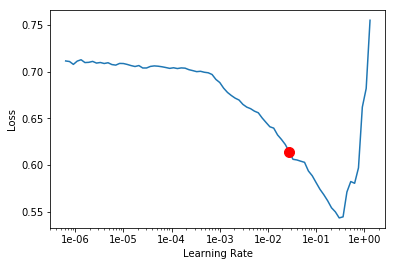

In [40]:
learn.recorder.plot(suggestion=True)

In [41]:
alpha = 1e-2
learn.fit_one_cycle(1, alpha, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.318212,0.226600,0.902946,00:07


In [15]:
learn.save('first')
learn.load('first');

From here on, we start to gradually unfreeze the layers and re-train the network, following the findings of the paper.

In [42]:
learn.freeze_to(-2)
alpha /= 2
learn.fit_one_cycle(1, slice(alpha/(2.6**4),alpha), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.307525,0.185602,0.928943,00:08


In [17]:
learn.save('second')
learn.load('second');

In [43]:
learn.freeze_to(-3)
alpha /= 2
learn.fit_one_cycle(1, slice(alpha/(2.6**4),alpha), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.255565,0.178561,0.933276,00:12


In [19]:
learn.save('third')
learn.load('third');

In [44]:
learn.unfreeze()
alpha /= 5
learn.fit_one_cycle(2, slice(alpha/(2.6**4),alpha), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.219360,0.160707,0.937608,00:18
1,0.189047,0.157505,0.940208,00:18


Let's save the final model for quicker future use.

In [45]:
learn.save('final')

## Checking results

In [46]:
if learn is None:
    learn = initialize_text_classifier()
learn.load('final');

In [47]:
score_train = learn.validate(data_clas.train_dl)[1].item()
score_test = learn.validate(data_clas.valid_dl)[1].item()

print("Train score = %f, test score = %f" % (score_train, score_test))

Train score = 0.961227, test score = 0.940208


Let's interpret the results some more. We can get the confusion matrix and the "most confused" samples:

In [48]:
interp = TextClassificationInterpretation.from_learner(learn)

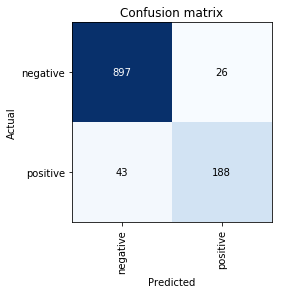

In [49]:
interp.plot_confusion_matrix()

In [50]:
interp.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
xxbos last 2 times i checked a bags they were xxunk damaged . xxmaj no one answers the baggage call line for status ? xxunk,negative,negative,5.22,0.99
"xxbos xxmaj its not just xxup phl , at xxup btv today made to deplane because "" it 's xxmaj sunday and we do n't know if maintenance will be available """,negative,negative,4.13,0.98
xxbos xxup dfw xxup gate 16 to xxup xxunk agent seriously is beyond incompetent . xxmaj never flying xxup aa again if can be xxunk fail pathetic,negative,negative,3.76,0.98
"xxbos and btw , the xxhan and xxhan managed on time departures same time same destination - & would n't take away a xxunk old kids bag !",negative,negative,3.21,0.96
xxbos xxmaj thank you ! ! ! xxmaj this whole crew has xxunk through bad weather and xxunk . xxmaj pilot keeping us well informed . customerservice,negative,positive,3.16,0.04


But this is not so informative, so I made a small modification to just show the ones with misclassified labels :-)

In [51]:
my_utils.show_top_losses_misclassified(interp, 5)

Text,Prediction,Actual,Loss,Probability
xxbos xxmaj thank you ! ! ! xxmaj this whole crew has xxunk through bad weather and xxunk . xxmaj pilot keeping us well informed . customerservice,negative,positive,3.16,0.04
"xxbos i listed my baggage claim number . xxmaj have them call me , my number is on the ticket . i had to use xxmaj lady xxmaj speed xxmaj stick this morning .",positive,negative,2.91,0.05
xxbos you guys are killing me . xxurl,positive,negative,2.60,0.07
xxbos xxhan they did n't address the assult or drinks xxunk on her the drunk passenger had to have a wheelchair to get off plane,positive,negative,2.02,0.13
"xxbos - thanks to the agent boarding xxunk , xxup atl - xxup aus . xxmaj left my wallet on the inbound . xxmaj he found it for me !",negative,positive,1.98,0.14


Let's show the predicted sentiment of some hand-made inputs:

In [52]:
examples = [
    "Awful flight",
    "Great trip, thanks to all",
    "attendant was rude!",
    "I thought I was going to have some great vacations, but everything was ruined by the delay and the rude service. Way, to go @VirginAmerica!",
    "first time with you, pretty fair :-) Food was ok"
]

for example in examples:
    pred = learn.predict(example)
    label = pred[1].item()
    probs = pred[2].tolist()
    print('%s\t%.3f\t%.3f\t%s' % ('-+'[label], probs[0], probs[1], example))

-	0.998	0.002	Awful flight
+	0.005	0.995	Great trip, thanks to all
-	0.570	0.430	attendant was rude!
-	0.907	0.093	I thought I was going to have some great vacations, but everything was ruined by the delay and the rude service. Way, to go @VirginAmerica!
+	0.480	0.520	first time with you, pretty fair :-) Food was ok


Let's see which words of our examples had the greatest contribution in the classification decision:

In [53]:
import matplotlib.cm as cm

for example in examples:
    interp.show_intrinsic_attention(example, cmap=cm.Reds)

We can do the same with some random training examples:

In [54]:
df_sample = df_labeled.sample(5)

for _, row in df_sample.iterrows():
    interp.show_intrinsic_attention(row.text, cmap=cm.Reds)

## Putting all together

Finally, we can compare with the baseline results:

In [74]:
results = {}
with open('data/results.pkl', 'rb') as f:
    prev_results = pickle.load(f)
    results.update(prev_results)

results['ulmfit_wt103'] = (score_train, score_test)

In [75]:
results_df = pd.DataFrame([(k, *v) for k, v in results.items()], columns=['method', 'score_train', 'score_test'])
results_df = results_df.sort_values(by='score_test', ascending=False)
results_df

,method,score_train,score_test
6,ulmfit_wt103,0.961227,0.940208
4,SVC_linear_10.0,0.951906,0.914982
1,nb_multi_counts,0.943385,0.903896
5,dtree,0.952051,0.880519
3,nb_gaussian_tf_idf_feature_sel,0.865107,0.811255
2,nb_gaussian_tf_idf,0.829097,0.687446
0,random_with_class_dist,0.674658,0.658874


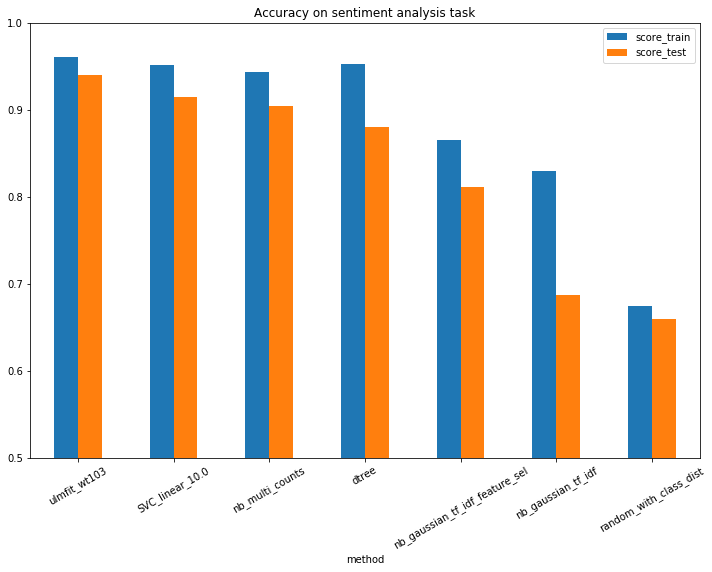

In [76]:
results_df.plot.bar(x='method', rot=30, ylim=(0.5, 1.0), figsize=(12, 8), title='Accuracy on sentiment analysis task')

In [77]:
with open('data/results2.pkl', 'wb') as f:
    pickle.dump(results, f)

## Discussion: weaknesses, potential improvements

- We can see that the ULMFiT model is superior to the other options, with a test accuracy slightly above 94%, which is around the state of the art.
- The Twitter dataset itself is not very big; with more training data and investing more time in tuning the hyperparameters, better results can be achieved.
- Since we are using transfer learning from a very powerful language model (WT-103), it is not necessary to invest too much time in NLP pre-processing of the text (as opposed to what was done with the baseline models in part 0).
- However, _some_ pre-processing had to be done due to the specific characteristics/idiosincracies of Twitter text:
  - hashtags had to be mostly converted into "regular" words
  - handlers (e.g. `@VirginAirlines`) have to be accounted for, since they can be too specific, they are mapped to dedicated token. The same applies to URLs, something that is not done out-of-the-box by the data loader.
  - Emojis and other characters can convey meaning, so we should try to keep them as "words".
- In the same line, the feature engineering of the tokens shows some weaknesses, that could be improved later:
  - Many people write in UPPERCASE in tweets to convey emotion; this is very different from the original Wikipedia language style. I suspect that this degrades the performance of the model (because the tokenizer actually detects and remembers those changing in casing). To solve it I would either:
    - fine-tune the language model with more training data, in order to learn those idiosincracies; or
    - pre-process the text to convert the uppercased words to "normal" (we would keep normally capitalized words though), although some sentiment information could be lost there.
    